In [2]:
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from gensim.utils import simple_preprocess
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix

import torch.nn as nn
from torch.optim import AdamW
from torch.utils.data import Dataset, DataLoader

from transformers import get_linear_schedule_with_warmup, AutoTokenizer, AutoModel, logging

import warnings
warnings.filterwarnings("ignore")

logging.set_verbosity_error()

In [3]:
def seed_everything(seed_value):
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    
    if torch.cuda.is_available(): 
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = True

seed_everything(86)

In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
EPOCHS = 10
N_SPLITS = 5

# Load data

In [5]:
# Đọc dữ liệu từ tệp CSV hoặc Excel
df = pd.read_csv('Comment_segement_OK.csv')

# Chia dữ liệu thành train và temporary data
train_temp, test_df = train_test_split(df, test_size=0.2, random_state=86)

# Tiếp tục chia train_temp thành train và validation
train_df, valid_df = train_test_split(train_temp, test_size=0.1, random_state=86)

# In kích thước của các tập dữ liệu
print("Số lượng mẫu trong tập train:", len(train_df))
print("Số lượng mẫu trong tập valid:", len(valid_df))
print("Số lượng mẫu trong tập test:", len(test_df))

Số lượng mẫu trong tập train: 20958
Số lượng mẫu trong tập valid: 2329
Số lượng mẫu trong tập test: 5822


In [6]:
# Thêm KFold vào
train_df = pd.concat([train_df, valid_df], ignore_index=True)
skf = StratifiedKFold(n_splits=N_SPLITS)
for fold, (_, val_) in enumerate(skf.split(X=train_df, y=train_df['sentiment'])):
    train_df.loc[val_, "kfold"] = fold

In [7]:
train_df.sample(5)

,sentence,sentiment,kfold
5964,trưởng_thành hơn cở s42 ultra rồi rước bả dzề ...,positive,1.0
8644,rất công_bằng và không hề nghiêng về bên nào,negative,1.0
7314,tốt lượng chuẩn không cần chỉnh,positive,1.0
2318,lương cơ_bản 3 tr đôwozy face,negative,0.0
22057,chỉ là cá_nhân nhưng_mà có_thể đọc quot_vi đê ...,negative,4.0


In [8]:
train_df.info(), test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23287 entries, 0 to 23286
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   sentence   23287 non-null  object 
 1   sentiment  23287 non-null  object 
 2   kfold      23287 non-null  float64
dtypes: float64(1), object(2)
memory usage: 545.9+ KB
<class 'pandas.core.frame.DataFrame'>
Index: 5822 entries, 8543 to 8998
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentence   5822 non-null   object
 1   sentiment  5822 non-null   object
dtypes: object(2)
memory usage: 136.5+ KB


(None, None)

<Axes: xlabel='sentiment', ylabel='count'>

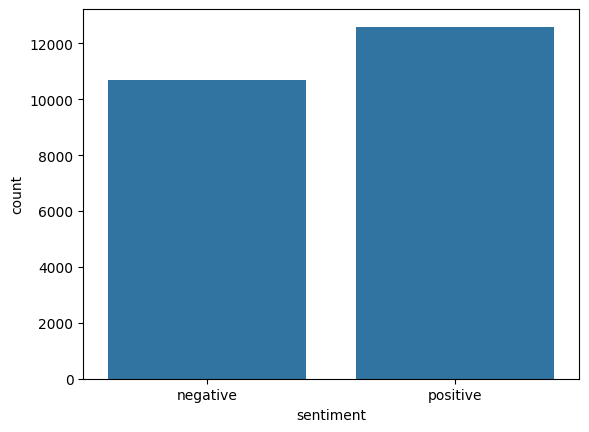

In [9]:
sns.countplot(x='sentiment',data=train_df)

In [10]:
tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base", use_fast=False)

In [11]:
# class SentimentDataset(Dataset):
#     def __init__(self, df, tokenizer, max_len=120):
#         self.df = df
#         self.max_len = max_len
#         self.tokenizer = tokenizer
    
#     def __len__(self):
#         return len(self.df)

#     def __getitem__(self, index):
#         """
#         To customize dataset, inherit from Dataset class and implement
#         __len__ & __getitem__
#         __getitem__ should return 
#             data:
#                 input_ids
#                 attention_masks
#                 text
#                 targets
#         """
#         row = self.df.iloc[index]
#         text, label = self.get_input_data(row)

#         # Encode_plus will:
#         # (1) split text into token
#         # (2) Add the '[CLS]' and '[SEP]' token to the start and end
#         # (3) Truncate/Pad sentence to max length
#         # (4) Map token to their IDS
#         # (5) Create attention mask
#         # (6) Return a dictionary of outputs
#         encoding = self.tokenizer.encode_plus(
#             text,
#             truncation=True,
#             add_special_tokens=True,
#             max_length=self.max_len,
#             padding='max_length',
#             return_attention_mask=True,
#             return_token_type_ids=False,
#             return_tensors='pt',
#         )
        
#         return {
#             'text': text,
#             'input_ids': encoding['input_ids'].flatten(),
#             'attention_masks': encoding['attention_mask'].flatten(),
#             'targets': torch.tensor(label, dtype=torch.long),
#         }


#     def labelencoder(self,text):
#         if text=='positive':
#             return 0
#         else:
#             return 1

def get_input_data(self, row):
    # Preprocessing: {remove icon, special character, lower}
    text = row['sentence']
    text = ' '.join(simple_preprocess(text))
    label = self.labelencoder(row['sentiment'])
    return text, label

BERT works with fixed-length sequences. We’ll use a simple strategy to choose the max length.

Text(0.5, 9.444444444444438, 'Token Count')

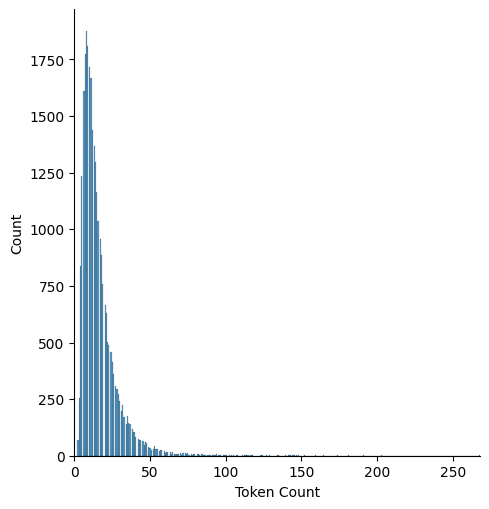

In [11]:
# Distribution of length of Sentence
all_data = train_df.sentence.tolist() + test_df.sentence.tolist()
all_data = [' '.join(simple_preprocess(text)) for text in all_data]
encoded_text = [tokenizer.encode(text, add_special_tokens=True) for text in all_data]
token_lens = [len(text) for text in encoded_text]
sns.displot(token_lens)
plt.xlim([0,max(token_lens)])
plt.xlabel('Token Count')

Choose a maximum of length of 60 is safe.

# Model

In [12]:
class SentimentClassifier(nn.Module):
    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.bert = AutoModel.from_pretrained("vinai/phobert-base")
        self.drop = nn.Dropout(p=0.3)
        self.fc = nn.Linear(self.bert.config.hidden_size, n_classes)
        nn.init.normal_(self.fc.weight, std=0.02)
        nn.init.normal_(self.fc.bias, 0)

    def forward(self, input_ids, attention_mask):
        last_hidden_state, output = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            return_dict=False # Dropout will errors if without this
        )

        x = self.drop(output)
        x = self.fc(x)
        return x

# Train & Eval Function

In [13]:
def train(model, criterion, optimizer, train_loader):
    model.train()
    losses = []
    correct = 0

    for data in train_loader:
        input_ids = data['input_ids'].to(device)
        attention_mask = data['attention_masks'].to(device)
        targets = data['targets'].to(device)

        optimizer.zero_grad()
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        loss = criterion(outputs, targets)
        _, pred = torch.max(outputs, dim=1)

        correct += torch.sum(pred == targets)
        losses.append(loss.item())
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        lr_scheduler.step()

    print(f'Train Accuracy: {correct.double()/len(train_loader.dataset)} Loss: {np.mean(losses)}')

def eval(test_data = False):
    model.eval()
    losses = []
    correct = 0

    with torch.no_grad():
        data_loader = test_loader if test_data else valid_loader
        for data in data_loader:
            input_ids = data['input_ids'].to(device)
            attention_mask = data['attention_masks'].to(device)
            targets = data['targets'].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )

            _, pred = torch.max(outputs, dim=1)

            loss = criterion(outputs, targets)
            correct += torch.sum(pred == targets)
            losses.append(loss.item())
    
    if test_data:
        print(f'Test Accuracy: {correct.double()/len(test_loader.dataset)} Loss: {np.mean(losses)}')
        return correct.double()/len(test_loader.dataset)
    else:
        print(f'Valid Accuracy: {correct.double()/len(valid_loader.dataset)} Loss: {np.mean(losses)}')
        return correct.double()/len(valid_loader.dataset)

# Training with K-Fold

In [14]:
def prepare_loaders(df, fold):
    df_train = train_df[train_df.kfold != fold].reset_index(drop=True)
    df_valid = train_df[train_df.kfold == fold].reset_index(drop=True)
    
    train_dataset = SentimentDataset(df_train, tokenizer, max_len=120)
    valid_dataset = SentimentDataset(df_valid, tokenizer, max_len=120)
    
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)
    valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=True, num_workers=2)
    
    return train_loader, valid_loader

In [15]:
print('kfold' in train_df.columns)

True


In [ ]:
for fold in range(skf.n_splits):
    print(f'-----------Fold: {fold+1} ------------------')
    train_loader, valid_loader = prepare_loaders(train, fold=fold)
    model = SentimentClassifier(n_classes=2).to(device)
    criterion = nn.CrossEntropyLoss()
    # Recommendation by BERT: lr: 5e-5, 2e-5, 3e-5
    # Batchsize: 16, 32
    optimizer = AdamW(model.parameters(), lr=2e-5)
    
    lr_scheduler = get_linear_schedule_with_warmup(
                optimizer, 
                num_warmup_steps=0, 
                num_training_steps=len(train_loader)*EPOCHS
            )
    best_acc = 0
    for epoch in range(EPOCHS):
        print(f'Epoch {epoch+1}/{EPOCHS}')
        print('-'*30)

        train(model, criterion, optimizer, train_loader)
        val_acc = eval()

        if val_acc > best_acc:
            torch.save(model.state_dict(), f'phobert_fold{fold+1}.pth')
            best_acc = val_acc

In [ ]:
def test(data_loader):
    models = []
    for fold in range(skf.n_splits):
        model = SentimentClassifier(n_classes=7)
        model.to(device)
        model.load_state_dict(torch.load(f'phobert_fold{fold+1}.pth'))
        model.eval()
        models.append(model)

    texts = []
    predicts = []
    predict_probs = []
    real_values = []

    for data in data_loader:
        text = data['text']
        input_ids = data['input_ids'].to(device)
        attention_mask = data['attention_masks'].to(device)
        targets = data['targets'].to(device)

        total_outs = []
        for model in models:
            with torch.no_grad():
                outputs = model(
                    input_ids=input_ids,
                    attention_mask=attention_mask
                )
                total_outs.append(outputs)
        
        total_outs = torch.stack(total_outs)
        _, pred = torch.max(total_outs.mean(0), dim=1)
        texts.extend(text)
        predicts.extend(pred)
        predict_probs.extend(total_outs.mean(0))
        real_values.extend(targets)
    
    predicts = torch.stack(predicts).cpu()
    predict_probs = torch.stack(predict_probs).cpu()
    real_values = torch.stack(real_values).cpu()
    print(classification_report(real_values, predicts))
    return real_values, predicts

In [ ]:
test_dataset = SentimentDataset(test_df, tokenizer, max_len=60)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True, num_workers=2)
real_values, predicts = test(test_loader)

# Heatmap between Predict and Ground Truth

In [ ]:
class_names = ['negative', 'positive']
sns.heatmap(confusion_matrix(real_values, predicts), annot=False, xticklabels = class_names, yticklabels = class_names)

# Visualize Wrong Predicted Label

In [ ]:
def check_wrong(real_values, predicts):
    wrong_arr = []
    wrong_label = []
    for i in range(len(predicts)):
        if predicts[i] != real_values[i]:
            wrong_arr.append(i)
            wrong_label.append(predicts[i])
    return wrong_arr, wrong_label

for i in range(15):
    print('-'*50)
    wrong_arr, wrong_label = check_wrong(real_values, predicts)
    print(test_df.iloc[wrong_arr[i]].Sentence)
    print(f'Predicted: ({class_names[wrong_label[i]]}) --vs-- Real label: ({class_names[real_values[wrong_arr[i]]]})')

# Inference

In [ ]:
def infer(text, tokenizer, max_len=120):
    encoded_review = tokenizer.encode_plus(
        text,
        max_length=max_len,
        truncation=True,
        add_special_tokens=True,
        padding='max_length',
        return_attention_mask=True,
        return_token_type_ids=False,
        return_tensors='pt',
    )

    input_ids = encoded_review['input_ids'].to(device)
    attention_mask = encoded_review['attention_mask'].to(device)

    output = model(input_ids, attention_mask)
    _, y_pred = torch.max(output, dim=1)

    print(f'Text: {text}')
    print(f'Sentiment: {class_names[y_pred]}')

In [7]:
import os
import re
import torch
import numpy as np
import pandas as pd
from underthesea import word_tokenize # Thư viện tách từ
from sklearn.model_selection import train_test_split, GridSearchCV # Thư viện chia tách và tối ưu hóa dữ liệu
from sklearn.svm import SVC
from joblib import dump
from transformers import AutoModel, AutoTokenizer # Thư viện BERT

file_path = 'Comment_segement_OK.csv'
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

def load_bert():
    model = AutoModel.from_pretrained("vinai/phobert-base")
    tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base", use_fast=False)
    return model, tokenizer

def standardize_data(row):
    row = re.sub(r"[\.,\?]+$-", "", row)
    row = re.sub(r"[,.;“:”\"'!?\-]", " ", row)
    return row.strip().lower()

def load_stopwords(filepath="vietnamese-stopwords.txt"):
    with open(filepath, encoding='utf-8') as f:
        stopwords = [line.strip() for line in f.readlines()]
    return stopwords

def load_data(filepath=file_path):
    df = pd.read_csv(filepath, encoding='utf-8')
    df['cleaned'] = df['sentence'].apply(standardize_data)
    return df['cleaned'].values, df['sentiment'].values

def make_bert_features(texts, tokenizer, model, max_len=60, stopwords=[]):
    tokenized = []
    for text in texts:
        text = " ".join([word for word in word_tokenize(text) if word not in stopwords])
        encoded = tokenizer.encode(text, max_length=max_len, truncation=True, padding='max_length')
        tokenized.append(encoded)

    padded = np.array(tokenized)
    attention_mask = np.where(padded != 1, 1, 0)

    padded = torch.tensor(padded).to(torch.long)
    attention_mask = torch.tensor(attention_mask)

    with torch.no_grad():
        last_hidden_states = model(input_ids=padded, attention_mask=attention_mask)
    features = last_hidden_states[0][:, 0, :].numpy()
    return features



In [8]:
# Log messages
print("Chuẩn bị nạp danh sách các từ vô nghĩa (stopwords)...")
sw = load_stopwords()
print("Đã nạp xong danh sách các từ vô nghĩa")

print("Chuẩn bị nạp model BERT....")
phobert, tokenizer = load_bert()
print("Đã nạp xong model BERT.")

print("Chuẩn bị load dữ liệu....")
text, label = load_data()
print("Đã load dữ liệu xong")

print("Chuẩn bị tạo features từ BERT.....")
features = make_bert_features(text, tokenizer, phobert, stopwords=sw)
print("Đã tạo xong features từ BERT")

Chuẩn bị nạp danh sách các từ vô nghĩa (stopwords)...
Đã nạp xong danh sách các từ vô nghĩa
Chuẩn bị nạp model BERT....
Đã nạp xong model BERT.
Chuẩn bị load dữ liệu....
Đã load dữ liệu xong
Chuẩn bị tạo features từ BERT.....


In [ ]:
# Phân chia dữ liệu train, test
X_train, X_test, y_train, y_test = train_test_split(features, label, test_size=0.2, random_state=86)


parameters = {'kernel': ('linear', 'rbf'), 'C': [1, 2, 4], 'gamma': [0.125, 0.25, 0.5, 1, 2, 4]}
from sklearn.model_selection import GridSearchCV
clf = GridSearchCV(SVC(), param_grid=parameters)
grid_search = clf.fit(X_train, y_train)

print("Best score: %0.3f" % grid_search.best_score_)
print(grid_search.best_estimator_)

# best prarams
print('best prarams:', clf.best_params_)

print("Chuẩn bị train model SVM....")
cl = SVC(kernel='linear', probability=True, gamma=0.125)
cl.fit(features, label)

sc = cl.score(X_test, y_test)
print('Kết quả train model, độ chính xác = ', sc*100, '%')

# Save model
dump(cl, 'save_model.pkl')
print("Đã lưu model SVM vào file save_model.pkl")